In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import random
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device

device(type='cuda', index=0)

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        label = self.labels_df.iloc[idx, 2] if 'Labels' in self.labels_df.columns else -1
        label = label.astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
batch_size = 8

In [4]:
# Data augmentation and normalization for training
scale_factor = 16
width = int(6000/scale_factor)
height = int(4000/scale_factor)
transform = transforms.Compose([
    transforms.Resize((height,width)),
    #transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(224, padding=4),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#width = 224
#height = 224

In [5]:
train_dataset = CustomDataset(csv_file='train.csv', img_dir='images/kaggle/working/Reorganized_Data/images', transform=transform)
#test_dataset = CustomDataset(csv_file='/kaggle/input/computer-vision-xm/test.csv', img_dir='/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images', transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


In [6]:
def get_gpu_dataloader(dataset,batch_size=1,shuffle=False):
    data = []
    labels = []
    for img, label in tqdm(dataset):
        data.append(img)
        labels.append(label)

    data = torch.stack(data)
    labels = torch.tensor(labels)

    data = data.to(device)
    labels = labels.to(device)

    loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(data, labels),
    batch_size=batch_size, shuffle=shuffle)
    return loader

In [7]:
# Create data loaders
train_loader = get_gpu_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = get_gpu_dataloader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = get_gpu_dataloader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 678/678 [00:53<00:00, 12.56it/s]


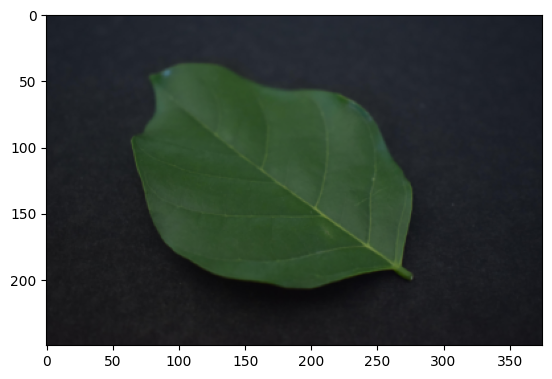

0.0


In [8]:
import torchvision.utils

import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataset)
next(dataiter)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes=1):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),

            #nn.Conv2d(64, 64, kernel_size=9, padding=4),
            #nn.BatchNorm2d(64),
            #nn.ReLU(inplace=True),
            #nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 16, kernel_size=15, padding=7),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4, 4),


            #nn.Conv2d(16, 16, kernel_size=1),
            #nn.BatchNorm2d(16),
            #nn.ReLU(inplace=True),
            #nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16 * int(width/(2**7)) * int(height/(2**7)), 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.reshape(-1)
    
model = CNN()
model = model.to(device)

In [10]:
# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Move the model to GPU if available
print(device)
model.to(device)

# Training loop with early stopping
epochs = 1000
patience = 10
best_val_loss = float('inf')
best_val_acc = 0
patience_counter = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training"):
        #images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.detach().item()

        # Backward pass
        loss.backward()
        optimizer.step()

    #scheduler.step()
    print(f'Training loss: {running_loss / len(train_loader)}')
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            #images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Convert the outputs to predicted class labels
            predicted = (outputs>0.5).float() #torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f'Validation loss: {val_loss / len(val_loader)}')
    print(f'Validation accuracy: {val_accuracy:.4f}')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        patience_counter = patience_counter - 1 if patience_counter > 0 else 0
        torch.save(model.state_dict(), 'best_acc_model.pth')
        print(f'Best model saved with valid acc of {val_accuracy:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_val_model.pth')
        print(f'Best model saved with valid loss of {val_loss / len(val_loader)}')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Total number of parameters: 98785
cuda:0
Epoch 1/1000


Training: 100%|██████████| 271/271 [00:02<00:00, 112.16it/s]


Training loss: 0.6771667254366998


Validation: 100%|██████████| 68/68 [00:00<00:00, 331.25it/s]


Validation loss: 0.576768229551175
Validation accuracy: 0.7362
Best model saved with valid acc of 0.7362
Best model saved with valid loss of 0.576768229551175
Epoch 2/1000


Training: 100%|██████████| 271/271 [00:02<00:00, 128.39it/s]


Training loss: 0.5851279938133


Validation: 100%|██████████| 68/68 [00:00<00:00, 370.36it/s]


Validation loss: 0.5274730616194361
Validation accuracy: 0.7675
Best model saved with valid acc of 0.7675
Best model saved with valid loss of 0.5274730616194361
Epoch 3/1000


Training: 100%|██████████| 271/271 [00:02<00:00, 129.02it/s]


Training loss: 0.5025902409175226


Validation: 100%|██████████| 68/68 [00:00<00:00, 369.99it/s]


Validation loss: 0.412437086157939
Validation accuracy: 0.8155
Best model saved with valid acc of 0.8155
Best model saved with valid loss of 0.412437086157939
Epoch 4/1000


Training: 100%|██████████| 271/271 [00:02<00:00, 128.87it/s]


Training loss: 0.4303352486383431


Validation: 100%|██████████| 68/68 [00:00<00:00, 371.12it/s]


Validation loss: 0.3338510632953223
Validation accuracy: 0.8745
Best model saved with valid acc of 0.8745
Best model saved with valid loss of 0.3338510632953223
Epoch 5/1000


Training: 100%|██████████| 271/271 [00:02<00:00, 135.49it/s]


Training loss: 0.34970909832698394


Validation: 100%|██████████| 68/68 [00:00<00:00, 394.28it/s]


Validation loss: 0.3567220350617872
Validation accuracy: 0.8450
Epoch 6/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.81it/s]


Training loss: 0.30558887866370354


Validation: 100%|██████████| 68/68 [00:00<00:00, 402.26it/s]


Validation loss: 0.28705105870304737
Validation accuracy: 0.8838
Best model saved with valid acc of 0.8838
Best model saved with valid loss of 0.28705105870304737
Epoch 7/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 138.03it/s]


Training loss: 0.26133046608514454


Validation: 100%|██████████| 68/68 [00:00<00:00, 393.05it/s]


Validation loss: 0.23238083117586725
Validation accuracy: 0.9133
Best model saved with valid acc of 0.9133
Best model saved with valid loss of 0.23238083117586725
Epoch 8/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.78it/s]


Training loss: 0.22381899810337713


Validation: 100%|██████████| 68/68 [00:00<00:00, 398.84it/s]


Validation loss: 0.20378480517469785
Validation accuracy: 0.9280
Best model saved with valid acc of 0.9280
Best model saved with valid loss of 0.20378480517469785
Epoch 9/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.98it/s]


Training loss: 0.21414292905122262


Validation: 100%|██████████| 68/68 [00:00<00:00, 398.65it/s]


Validation loss: 0.21059412049020038
Validation accuracy: 0.9077
Epoch 10/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.46it/s]


Training loss: 0.200432491450952


Validation: 100%|██████████| 68/68 [00:00<00:00, 395.59it/s]


Validation loss: 0.17412060243077576
Validation accuracy: 0.9280
Best model saved with valid loss of 0.17412060243077576
Epoch 11/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.53it/s]


Training loss: 0.1957534229592506


Validation: 100%|██████████| 68/68 [00:00<00:00, 393.98it/s]


Validation loss: 0.1607165702016038
Validation accuracy: 0.9428
Best model saved with valid acc of 0.9428
Best model saved with valid loss of 0.1607165702016038
Epoch 12/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.49it/s]


Training loss: 0.16636968977711544


Validation: 100%|██████████| 68/68 [00:00<00:00, 395.13it/s]


Validation loss: 0.18060238571727977
Validation accuracy: 0.9336
Epoch 13/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.07it/s]


Training loss: 0.15807373308047404


Validation: 100%|██████████| 68/68 [00:00<00:00, 399.68it/s]


Validation loss: 0.1598325418719255
Validation accuracy: 0.9336
Best model saved with valid loss of 0.1598325418719255
Epoch 14/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.81it/s]


Training loss: 0.15444579670150727


Validation: 100%|██████████| 68/68 [00:00<00:00, 398.11it/s]


Validation loss: 0.1504695858422886
Validation accuracy: 0.9428
Best model saved with valid loss of 0.1504695858422886
Epoch 15/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.60it/s]


Training loss: 0.13505151553244443


Validation: 100%|██████████| 68/68 [00:00<00:00, 398.20it/s]


Validation loss: 0.14295413697768442
Validation accuracy: 0.9483
Best model saved with valid acc of 0.9483
Best model saved with valid loss of 0.14295413697768442
Epoch 16/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 138.44it/s]


Training loss: 0.12287663639011033


Validation: 100%|██████████| 68/68 [00:00<00:00, 400.08it/s]


Validation loss: 0.16407186240779564
Validation accuracy: 0.9465
Epoch 17/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 138.01it/s]


Training loss: 0.1251084641605011


Validation: 100%|██████████| 68/68 [00:00<00:00, 396.41it/s]


Validation loss: 0.12929332483669415
Validation accuracy: 0.9557
Best model saved with valid acc of 0.9557
Best model saved with valid loss of 0.12929332483669415
Epoch 18/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.26it/s]


Training loss: 0.12089099412667136


Validation: 100%|██████████| 68/68 [00:00<00:00, 401.19it/s]


Validation loss: 0.1329330226598198
Validation accuracy: 0.9594
Best model saved with valid acc of 0.9594
Epoch 19/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.14it/s]


Training loss: 0.09746594217367903


Validation: 100%|██████████| 68/68 [00:00<00:00, 396.36it/s]


Validation loss: 0.15772541724693248
Validation accuracy: 0.9446
Epoch 20/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.71it/s]


Training loss: 0.1049876903472434


Validation: 100%|██████████| 68/68 [00:00<00:00, 398.07it/s]


Validation loss: 0.20794977857012248
Validation accuracy: 0.9317
Epoch 21/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.42it/s]


Training loss: 0.08672370606469768


Validation: 100%|██████████| 68/68 [00:00<00:00, 399.44it/s]


Validation loss: 0.11877771846347433
Validation accuracy: 0.9539
Best model saved with valid loss of 0.11877771846347433
Epoch 22/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.35it/s]


Training loss: 0.08409326595861664


Validation: 100%|██████████| 68/68 [00:00<00:00, 390.08it/s]


Validation loss: 0.1261159904705196
Validation accuracy: 0.9557
Epoch 23/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.96it/s]


Training loss: 0.07473694390082058


Validation: 100%|██████████| 68/68 [00:00<00:00, 400.64it/s]


Validation loss: 0.12386945492985166
Validation accuracy: 0.9631
Best model saved with valid acc of 0.9631
Epoch 24/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 138.21it/s]


Training loss: 0.07855269890188367


Validation: 100%|██████████| 68/68 [00:00<00:00, 396.43it/s]


Validation loss: 0.1580655150781454
Validation accuracy: 0.9483
Epoch 25/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.98it/s]


Training loss: 0.09079108176953966


Validation: 100%|██████████| 68/68 [00:00<00:00, 395.32it/s]


Validation loss: 0.12891677630079143
Validation accuracy: 0.9520
Epoch 26/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 136.83it/s]


Training loss: 0.06470171259621646


Validation: 100%|██████████| 68/68 [00:00<00:00, 397.13it/s]


Validation loss: 0.15380394657019197
Validation accuracy: 0.9502
Epoch 27/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.35it/s]


Training loss: 0.06612775650075585


Validation: 100%|██████████| 68/68 [00:00<00:00, 394.13it/s]


Validation loss: 0.23527568940206786
Validation accuracy: 0.9428
Epoch 28/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 138.25it/s]


Training loss: 0.054959684154854284


Validation: 100%|██████████| 68/68 [00:00<00:00, 394.38it/s]


Validation loss: 0.17243197897658
Validation accuracy: 0.9354
Epoch 29/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 137.56it/s]


Training loss: 0.059890408785644285


Validation: 100%|██████████| 68/68 [00:00<00:00, 402.79it/s]


Validation loss: 0.1384725161393255
Validation accuracy: 0.9539
Epoch 30/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 136.82it/s]


Training loss: 0.06333343891718604


Validation: 100%|██████████| 68/68 [00:00<00:00, 397.85it/s]


Validation loss: 0.20431823521357728
Validation accuracy: 0.9446
Epoch 31/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 136.84it/s]


Training loss: 0.05281368346905896


Validation: 100%|██████████| 68/68 [00:00<00:00, 393.70it/s]


Validation loss: 0.14957336883226696
Validation accuracy: 0.9576
Epoch 32/1000


Training: 100%|██████████| 271/271 [00:01<00:00, 136.82it/s]


Training loss: 0.04453406383063708


Validation: 100%|██████████| 68/68 [00:00<00:00, 395.30it/s]

Validation loss: 0.14281108406259377
Validation accuracy: 0.9539
Early stopping triggered


In [11]:
model.load_state_dict(torch.load('best_val_model.pth'))
model.to(device)

# Make predictions on the test dataset
model.eval()
predictions = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        outputs = model(images)
        predicted = (outputs>0.5).float()
        labels.extend(label.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame with IDs and predictions
submission_df = pd.DataFrame({
    #'images': test_dataset.labels_df['Images'],
    'labels': predictions,
    'groundtruth': labels
})
#submission_df.to_csv('submission.csv', index=False)
#print('Submission file was created.')
(submission_df.labels == submission_df.groundtruth).mean()

np.float64(0.9587020648967551)

In [12]:
wrong_assesments = submission_df[submission_df.labels != submission_df.groundtruth]
false_positives = len(wrong_assesments[wrong_assesments.groundtruth == 1])
false_negatives = len(wrong_assesments[wrong_assesments.groundtruth == 0])
print(f"We have {false_positives} false positives and {false_negatives} false negatives!")

We have 16 false positives and 12 false negatives!


False negative - Healthy plant classified as sick:


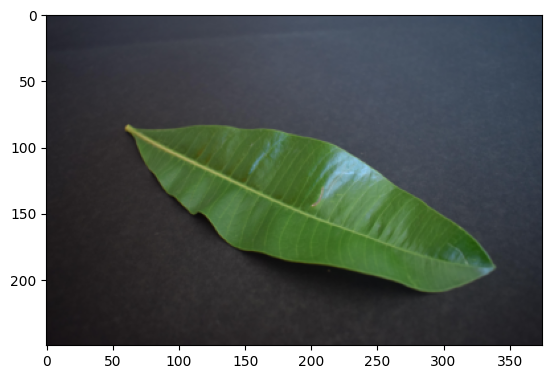

False positive - Sick plant classified as healthy:


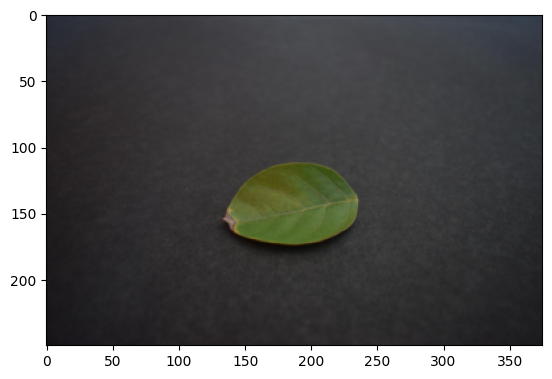

False positive - Sick plant classified as healthy:


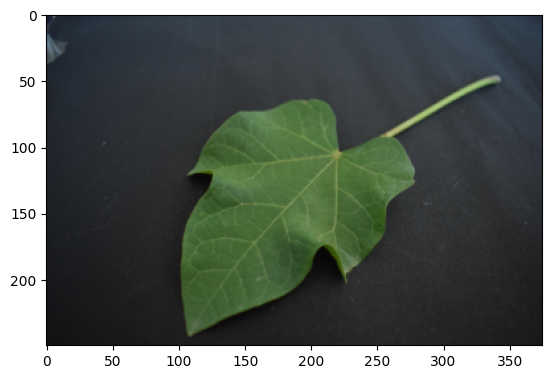

False positive - Sick plant classified as healthy:


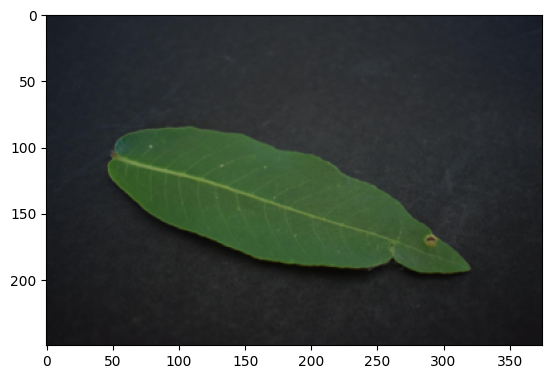

False negative - Healthy plant classified as sick:


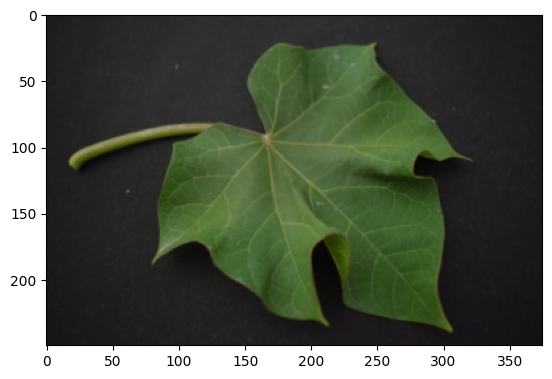

False positive - Sick plant classified as healthy:


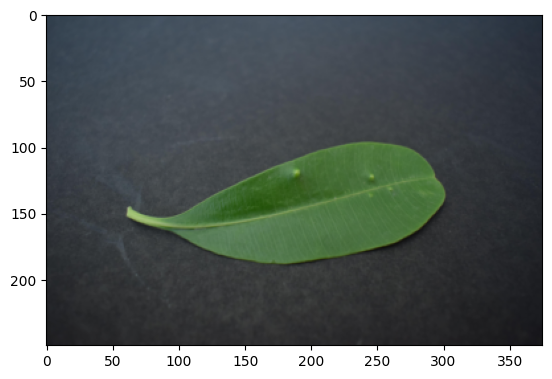

False positive - Sick plant classified as healthy:


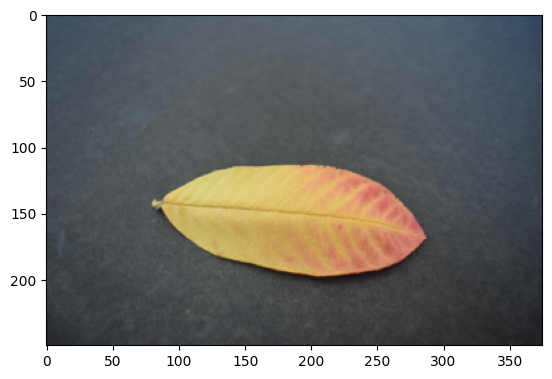

False negative - Healthy plant classified as sick:


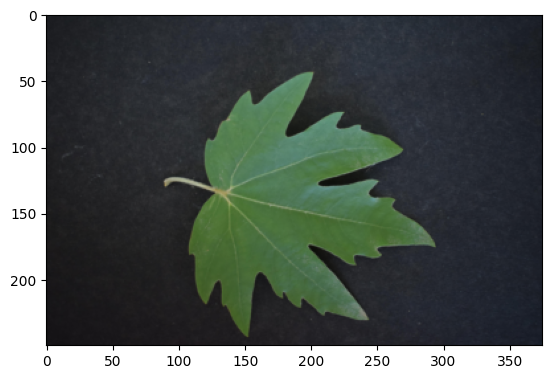

False positive - Sick plant classified as healthy:


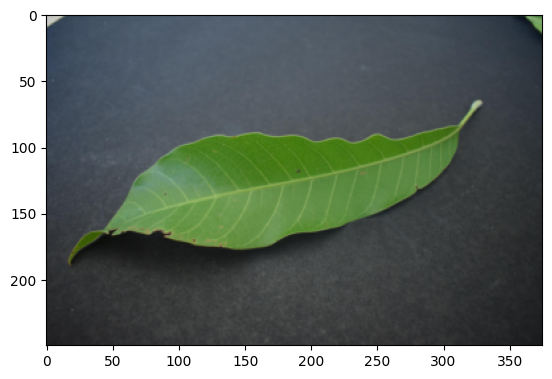

False positive - Sick plant classified as healthy:


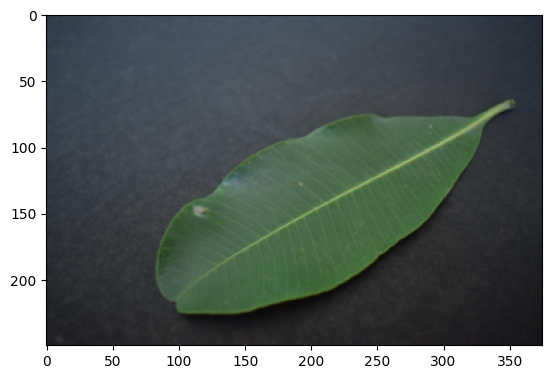

False negative - Healthy plant classified as sick:


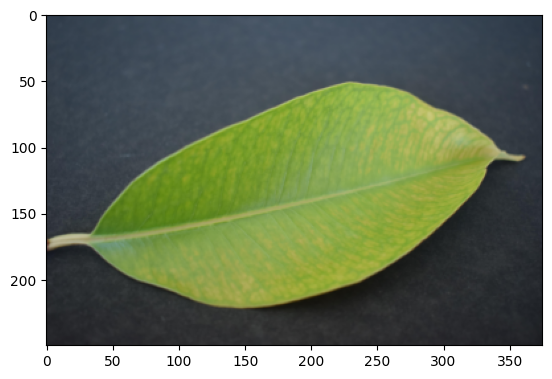

False positive - Sick plant classified as healthy:


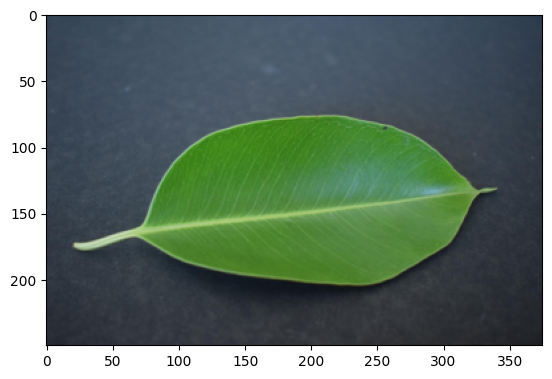

False negative - Healthy plant classified as sick:


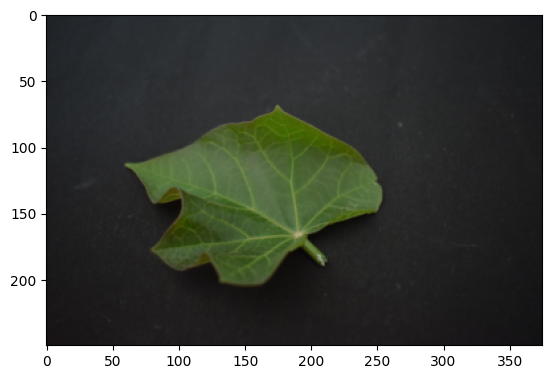

False positive - Sick plant classified as healthy:


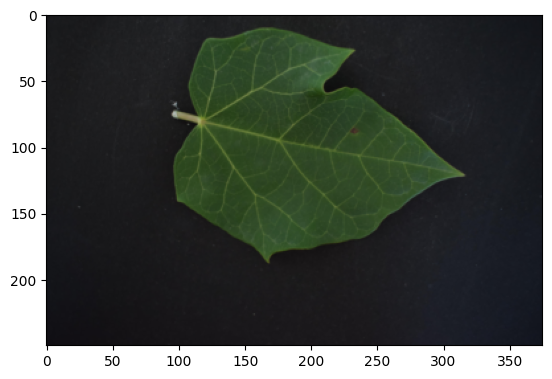

False negative - Healthy plant classified as sick:


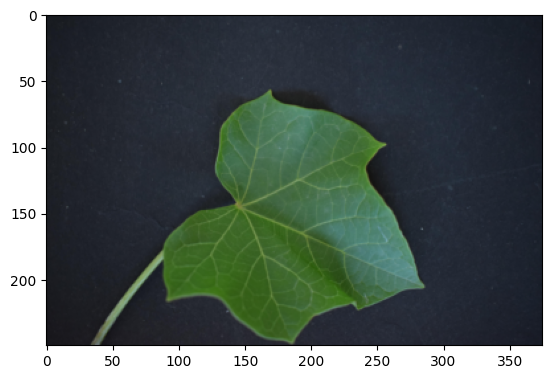

False negative - Healthy plant classified as sick:


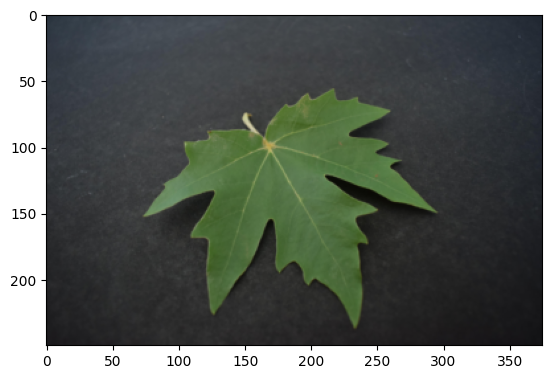

False negative - Healthy plant classified as sick:


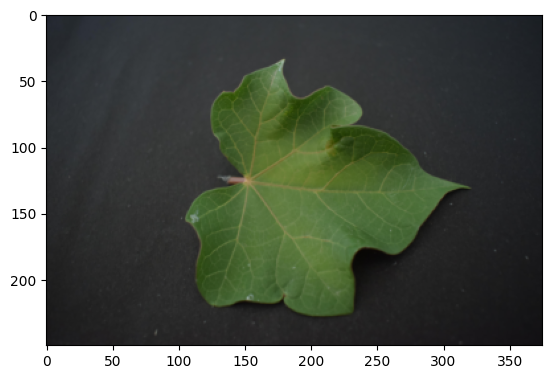

False positive - Sick plant classified as healthy:


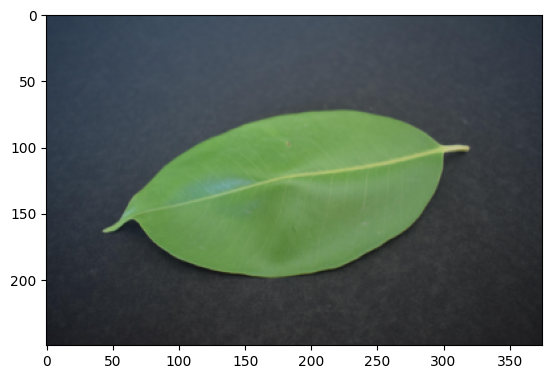

False positive - Sick plant classified as healthy:


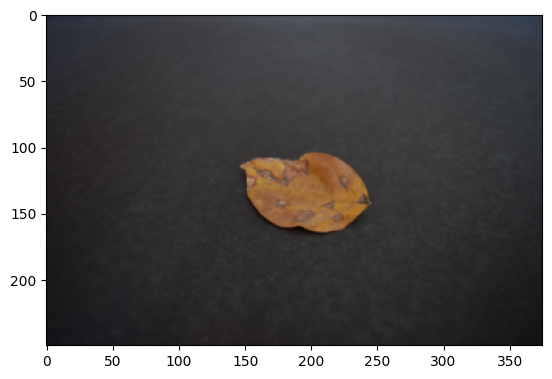

False positive - Sick plant classified as healthy:


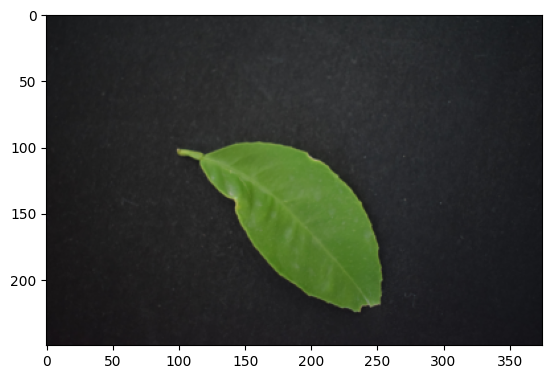

False negative - Healthy plant classified as sick:


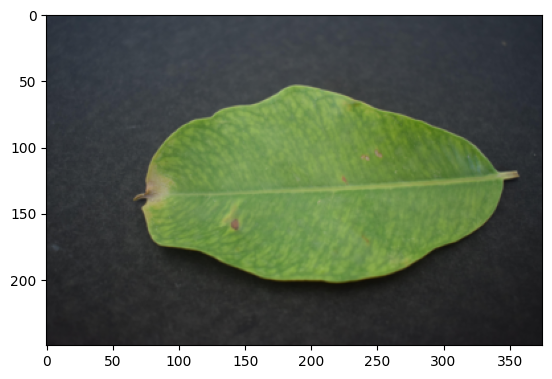

False negative - Healthy plant classified as sick:


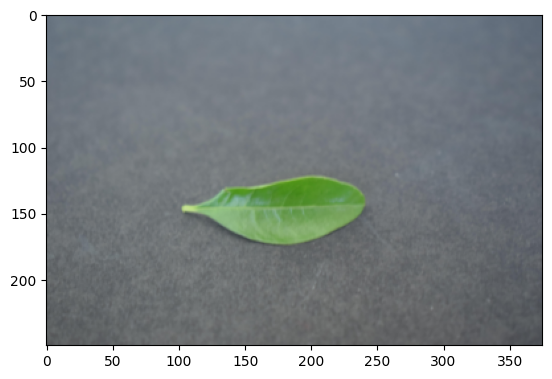

False positive - Sick plant classified as healthy:


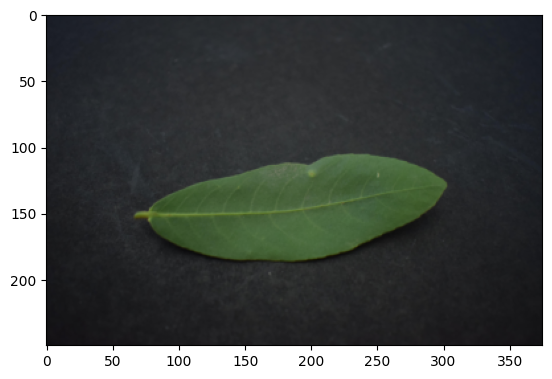

False positive - Sick plant classified as healthy:


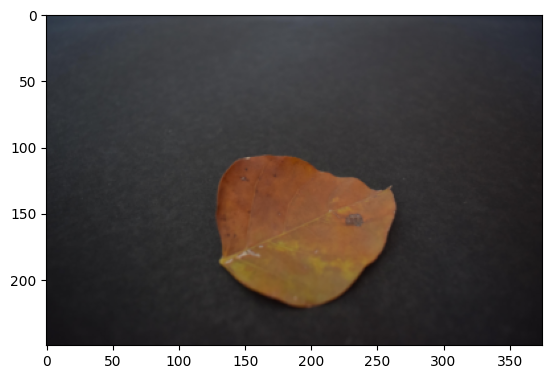

False negative - Healthy plant classified as sick:


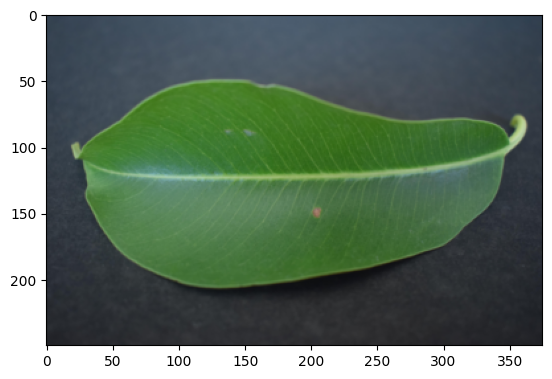

False positive - Sick plant classified as healthy:


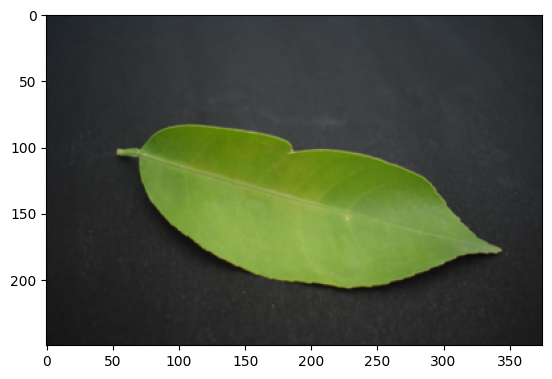

False positive - Sick plant classified as healthy:


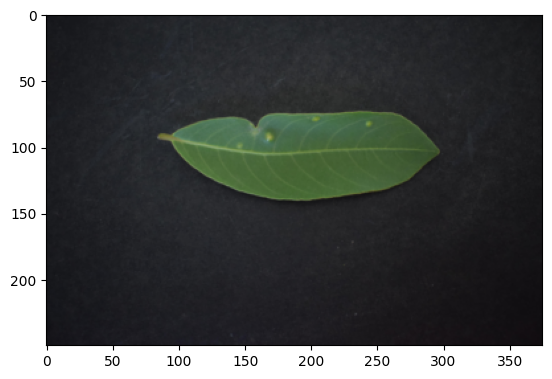

False negative - Healthy plant classified as sick:


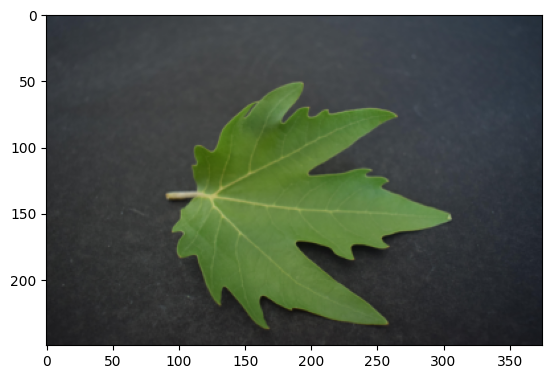

In [13]:
images = []
for idx, pred, truth in zip(wrong_assesments.index, wrong_assesments["labels"], wrong_assesments["groundtruth"]):
    if truth == 1:
        print("False positive - Sick plant classified as healthy:")
    else:
        print("False negative - Healthy plant classified as sick:")
    image, label = test_dataset[idx]
    imshow(image)
    images.append(image)

#def imshow(img):
#    img = img / 2 + 0.5     # unnormalize
#    npimg = img.numpy()
#    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#    plt.show()


# get some random training images
#dataiter = iter(train_dataset)
#next(dataiter)
#images, labels = next(dataiter)

# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(labels)

#test_loader

In [23]:
import time
image, label = test_dataset[idx]
image = image.unsqueeze(0)
model.cpu()
since = time.time()
model(image)
now = time.time()
now - since

0.009006023406982422